### Download text dataset from Kaggle

In [39]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakibulhasanshaon69/the-verdict-txt")

print("Path to dataset files:", path)

/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/mori/.cache/kagglehub/datasets/rakibulhasanshaon69/the-verdict-txt/versions/1


# Input Preparation

### Create Tokens

In [40]:
# Read the text file
with open("the-verdict.txt", "r") as f:
    raw_text = f.read()

print("Length of text:", len(raw_text))
print("First 100 characters:")
print(raw_text[:100])

Length of text: 20479
First 100 characters:
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [41]:
import re

# Tokenization using regex
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print("Number of tokens:", len(preprocessed))
print("First 30 tokens:", preprocessed[:30])

Number of tokens: 4690
First 30 tokens: ['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


### Create Token IDs

In [42]:
# Create unique words
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print("Vocabulary size:", vocab_size)

Vocabulary size: 1130


In [43]:
# Create vocabulary which includes unique words as well as their corresponding IDs by mapping each word to a unique integer (encoding)
vocab = {token: integer for integer, token in enumerate(all_words)}

In [44]:
for i, item in enumerate(vocab.items()):
    if i >= 20:
        break
    print(item)

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)


### Create Tokenizer Class

In [45]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # replace space before punctuation
        text = re.sub(r'\s+([,.:;?_!"()\'])', r'\1', text)
        return text

In [46]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," Mrs. Gisburn said with pardonable pride."""

ids = tokenizer.encode(text)
print("Encoded IDs:", ids)

Encoded IDs: [1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [47]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


In [48]:
# Unknown token example
text = "Hello, world! This is a test."
# print(tokenizer.encode(text))

### Add Special Content Tokens

In [49]:
all_tokens = sorted(list(set(preprocessed)))
# handle special tokens
all_tokens.extend(["<|endoftext|>","<|unk|>"])

vocab = {token: integer for integer, token in enumerate(all_tokens)}
print("New vocabulary size:", len(vocab))
print(list(vocab.items())[-5:]) 

New vocabulary size: 1132
[('younger', 1127), ('your', 1128), ('yourself', 1129), ('<|endoftext|>', 1130), ('<|unk|>', 1131)]


In [50]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # replace space before punctuation
        text = re.sub(r'\s+([,.:;?_!"()\'])', r'\1', text)
        return text

In [51]:
tokenizer = SimpleTokenizerV2(vocab)

In [52]:
# Unknown token example
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join([text1, text2])

print(text)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


### Byte Pair Encoding (subwords) to handle unknown words

In [53]:
import importlib
import tiktoken

print("titoken veriosn:", importlib.metadata.version("tiktoken"))

titoken veriosn: 0.11.0


In [54]:
# "gpt2" here refers to the pre-trained byte-level BPE tokenizer used by OpenAI's GPT-2 model.
# It is not your custom vocabulary, but a built-in encoding with its own vocabulary and merge rules.
# The tokenizer variable will use the GPT-2 vocabulary and rules, not the vocab or all_tokens defined above.
tokenizer = tiktoken.get_encoding("gpt2")

In [55]:
text = ("Hello, do you like tea? <|endoftext|> In the sunlit terraces" 
        " of someunknownplace.")

print(text)
ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print("Encoded IDs:", ids)
print(tokenizer.decode(ids))

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownplace.
Encoded IDs: [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 5372, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownplace.


In [56]:
ids = tokenizer.encode("Akwirw ier")
print("Encoded IDs for unknown words:", ids)

strings = tokenizer.decode(ids)
print("Decoded string for unknown words:", strings)

Encoded IDs for unknown words: [33901, 86, 343, 86, 220, 959]
Decoded string for unknown words: Akwirw ier


### Create input-target pair - Auto Regressive to train the LLM

In [57]:
with open("the-verdict.txt", "r") as f:
    raw_text = f.read()

# Encode the entire text using BPE tokenizer to create the vocabulary
enc_text = tokenizer.encode(raw_text)
print("Total tokens in the-verdict.txt:", len(enc_text))

Total tokens in the-verdict.txt: 5145


In [58]:
# For demostration purpose, we will use a small slice of the encoded text
enc_example = enc_text[50:]

In [59]:
# Sliding window size
context_size = 4

x = enc_example[:context_size]
y = enc_example[1:context_size+1]

print("Input sequence (x):", x)
print("Target sequence (y):     ", y)

Input sequence (x): [290, 4920, 2241, 287]
Target sequence (y):      [4920, 2241, 287, 257]


In [60]:
# Create input-target pairs for auto-regressive modeling for predicting next token and 4 predction tasks are performed
for i in range(1, context_size+1):

    context = enc_example[:i]
    desired = [enc_example[i]]

    print(f"Context (i={i}):", context, "-> Next token:", desired)

Context (i=1): [290] -> Next token: [4920]
Context (i=2): [290, 4920] -> Next token: [2241]
Context (i=3): [290, 4920, 2241] -> Next token: [287]
Context (i=4): [290, 4920, 2241, 287] -> Next token: [257]


In [61]:
# Create input-target pairs for auto-regressive modeling for predicting next token and 4 predction tasks are performed
for i in range(1, context_size+1):

    context = enc_example[:i]
    desired = [enc_example[i]]

    print(f"Context (i={i}):", tokenizer.decode(context), "-> Next token:", tokenizer.decode(desired))

Context (i=1):  and -> Next token:  established
Context (i=2):  and established -> Next token:  himself
Context (i=3):  and established himself -> Next token:  in
Context (i=4):  and established himself in -> Next token:  a


### Data Loader

https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

https://docs.pytorch.org/docs/stable/data.html

In [62]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [63]:
def create_dataloader_v1(txt, batchsize=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create the dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create the DataLoader
    dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [64]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [65]:
import torch

print("PyTorch version:", torch.__version__)

PyTorch version: 2.8.0


In [66]:
# Create DataLoader with batch size 1 for easy demonstration
dataloader = create_dataloader_v1(raw_text, batchsize=1, max_length=4, stride=1, shuffle=False)

data_iter = iter(dataloader)

first_batch = next(data_iter)
print("First batch (input_ids, target_ids):", first_batch)
second_batch = next(data_iter)
print("Second batch (input_ids, target_ids):", second_batch)

First batch (input_ids, target_ids): [tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
Second batch (input_ids, target_ids): [tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [67]:
# Create DataLoader with batch size 8 
dataloader = create_dataloader_v1(raw_text, batchsize=8, max_length=4, stride=1, shuffle=False)

data_iter = iter(dataloader)

first_batch = next(data_iter)
print("First batch (input_ids, target_ids):", first_batch)

First batch (input_ids, target_ids): [tensor([[   40,   367,  2885,  1464],
        [  367,  2885,  1464,  1807],
        [ 2885,  1464,  1807,  3619],
        [ 1464,  1807,  3619,   402],
        [ 1807,  3619,   402,   271],
        [ 3619,   402,   271, 10899],
        [  402,   271, 10899,  2138],
        [  271, 10899,  2138,   257]]), tensor([[  367,  2885,  1464,  1807],
        [ 2885,  1464,  1807,  3619],
        [ 1464,  1807,  3619,   402],
        [ 1807,  3619,   402,   271],
        [ 3619,   402,   271, 10899],
        [  402,   271, 10899,  2138],
        [  271, 10899,  2138,   257],
        [10899,  2138,   257,  7026]])]


### Token Embedding

Input Text -> Tokenized Text -> Token IDs -> Token Embedding -> Capture Semantic Meaning

In [68]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")  # 300-dimensional Word2Vec vectors trained on Google News

In [69]:
word_vectors = model

In [70]:
print(word_vectors["king"])

[ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582031e-02
  1.85546875e-01  4.47265

In [71]:
word_vectors.most_similar(positive=["king", "woman"], negative=["man"], topn=5)

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133)]

In [72]:
word_vectors.similarity("king", "queen")

0.6510956

Embedding layer itself as look up table

In [73]:
input_ids = torch.tensor([2, 3, 5, 1])

In [74]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)  # For reproducibility
embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=output_dim)

In [75]:
# Initial weights of the embedding layer before training
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [76]:
# Treat as lookup table operation
print(embedding_layer(torch.tensor(2)))

tensor([ 1.2753, -0.2010, -0.1606], grad_fn=<EmbeddingBackward0>)


In [77]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


### Positional Encoding

In [78]:
vocab_size = 50257 # GPT-2 vocabulary size
output_dim = 256  # Common dimension used in many transformer models

token_embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=output_dim)
print("Token embedding layer weights shape:", token_embedding_layer.weight.shape)

Token embedding layer weights shape: torch.Size([50257, 256])


In [79]:
max_length= 4

data_loader = create_dataloader_v1(raw_text, batchsize=8, max_length=max_length, stride=max_length, shuffle=False)

In [80]:
data_iter = iter(data_loader)
input_ids, target_ids = next(data_iter)

print("Input IDs shape:", input_ids.shape)
print("Target IDs shape:", target_ids.shape)
print("Input IDs:", input_ids)  
print("Target IDs:", target_ids)

Input IDs shape: torch.Size([8, 4])
Target IDs shape: torch.Size([8, 4])
Input IDs: tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
Target IDs: tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [81]:
token_embeddings = token_embedding_layer(input_ids)
print("Token embeddings shape:", token_embeddings.shape)
print("Token embeddings:", token_embeddings)

Token embeddings shape: torch.Size([8, 4, 256])
Token embeddings: tensor([[[ 0.4913,  1.1239,  1.4588,  ..., -0.3995, -1.8735, -0.1445],
         [ 0.4481,  0.2536, -0.2655,  ...,  0.4997, -1.1991, -1.1844],
         [-0.2507, -0.0546,  0.6687,  ...,  0.9618,  2.3737, -0.0528],
         [ 0.9457,  0.8657,  1.6191,  ..., -0.4544, -0.7460,  0.3483]],

        [[ 1.5460,  1.7368, -0.7848,  ..., -0.1004,  0.8584, -0.3421],
         [-1.8622, -0.1914, -0.3812,  ...,  1.1220, -0.3496,  0.6091],
         [ 1.9847, -0.6483, -0.1415,  ..., -0.3841, -0.9355,  1.4478],
         [ 0.9647,  1.2974, -1.6207,  ...,  1.1463,  1.5797,  0.3969]],

        [[-0.7713,  0.6572,  0.1663,  ..., -0.8044,  0.0542,  0.7426],
         [ 0.8046,  0.5047,  1.2922,  ...,  1.4648,  0.4097,  0.3205],
         [ 0.0795, -1.7636,  0.5750,  ...,  2.1823,  1.8231, -0.3635],
         [ 0.4267, -0.0647,  0.5686,  ..., -0.5209,  1.3065,  0.8473]],

        ...,

        [[-1.6156,  0.9610, -2.6437,  ..., -0.9645,  1.0888,  

In [82]:
context_length = max_length

pos_embeddings = torch.nn.Embedding(num_embeddings=context_length, embedding_dim=output_dim)
print("Positional embeddings shape:", pos_embeddings.weight.shape)

Positional embeddings shape: torch.Size([4, 256])


In [83]:
input_embeddings = token_embeddings + pos_embeddings(torch.arange(context_length))
print("Input embeddings shape:", input_embeddings.shape)

Input embeddings shape: torch.Size([8, 4, 256])


In [84]:
torch.arange(context_length)

tensor([0, 1, 2, 3])

In [85]:
# No need to run this line again, it's just for demonstration for not-existing variable error
# pos_embeddings(torch.tensor(5))

### Data Processing Pipeline

1. Tokenization (word-based, subword-based(BPE), character-based)

2. Token Embedding (converting token IDs to vectors)

3. Positional Embedding (encoding info about positions)

4. Input Embedding (Token Embedding + Positional Embedding)


# Attention Mechanism

### Simplified Attention

In [86]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1) 
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [87]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

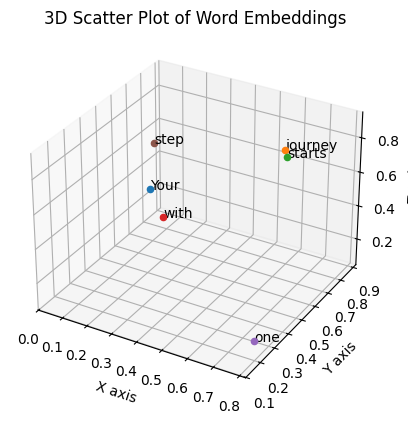

In [88]:
words = ["Your", "journey", "starts", "with", "one", "step"]

# Extract x, y, z coordinates
x = inputs[:, 0].numpy()
y = inputs[:, 1].numpy()
z = inputs[:, 2].numpy()

# Create 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for word, x_coord, y_coord, z_coord in zip(words, x, y, z):
    ax.scatter(x_coord, y_coord, z_coord)
    ax.text(x_coord, y_coord, z_coord, word)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title('3D Scatter Plot of Word Embeddings')
plt.show()


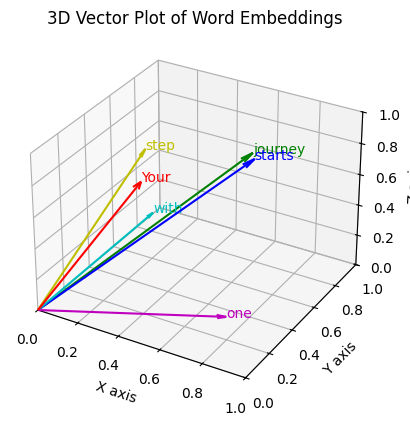

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of color for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color with annotated word
for (x,y,z), word, color in zip(inputs.numpy(), words, colors):
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word,fontsize=10, color=color)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')     
ax.set_zlabel('Z axis')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Vector Plot of Word Embeddings')
plt.show()

In [90]:
print("Input shape:", inputs.shape)

Input shape: torch.Size([6, 3])


In [91]:
query = inputs[1] # journey (x^2)

attn_scores_2 = torch.empty(inputs.shape[0])
for i in range(inputs.shape[0]):
    attn_scores_2[i] = torch.dot(query, inputs[i])  

print("Attention scores for 'journey':", attn_scores_2)

Attention scores for 'journey': tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [92]:
# Naive implementation: Normalize the attention scores using softmax to get attention weights

attn_weights_2_tmp = attn_scores_2 / torch.sum(attn_scores_2)

print("Attention weights for 'journey':", attn_weights_2_tmp)
print("Sum of attention weights:", torch.sum(attn_weights_2_tmp))

Attention weights for 'journey': tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum of attention weights: tensor(1.0000)


In [93]:
# softmax implementation

def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [94]:
# Pytorch softmax implementation
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


tensor([0.4419, 0.6515, 0.5683])


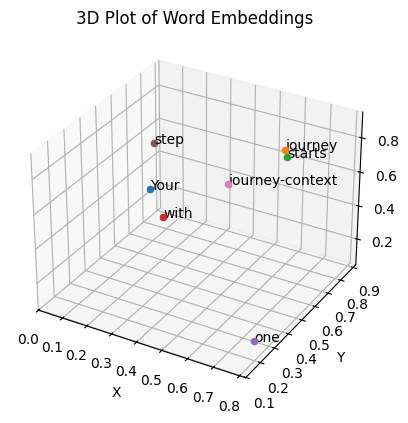

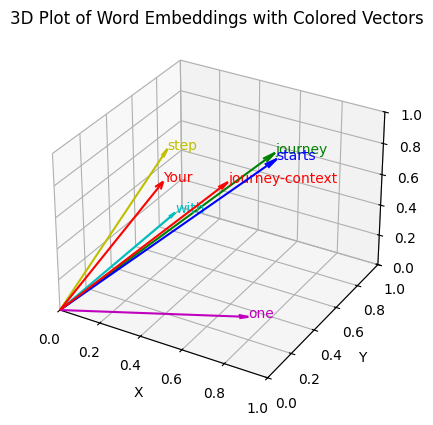

In [95]:
# Create context vector as weighted sum of value vectors

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

inputs2 = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   context_vec_2]
)


# Corresponding words
words2 = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs2[:, 0].numpy()
y_coords = inputs2[:, 1].numpy()
z_coords = inputs2[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words2):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words2, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

In [96]:
# Compute attention scores for all query-key pairs
attn_scores = torch.empty(inputs.shape[0], inputs.shape[0])

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [97]:
# Compute attention scores by matrix multiplication which is more efficient
attn_scores_matmul = torch.matmul(inputs, inputs.T)
print(attn_scores_matmul)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [98]:
# Normalize the attention scores using softmax to get attention weights
attn_weights = torch.softmax(attn_scores_matmul, dim=-1)
print("Attention weights for 'journey':\n", attn_weights)

Attention weights for 'journey':
 tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [99]:
# Sum along the last dimension which is along the columns to verify that they sum to 1
print("All row sums:", attn_weights.sum(dim=-1))

All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [100]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


### Self Attention -> Scaled dot-product Attention

In [101]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1) 
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [102]:
x_2 = inputs[1] # 2nd input token is the query
d_in = inputs.shape[1] # input dimension

d_out = 2

In [103]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [104]:
print(W_query)
print(W_key)
print(W_value)

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])
Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])
Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


In [105]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


In [106]:
keys = inputs @ W_key
values = inputs @ W_value
queries = inputs @ W_query
print("keys.shape:", keys.shape)

print("values.shape:", values.shape)

print("queries.shape:", queries.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])
queries.shape: torch.Size([6, 2])


In [107]:
keys_2 = keys[1] #A
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [108]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [109]:
attn_scores = queries @ keys.T # omega
print(attn_scores)

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])


In [110]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)
print(d_k)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
2


In [111]:
import torch

# Define the tensor
tensor = torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])

# Apply softmax without scaling
softmax_result = torch.softmax(tensor, dim=-1)
print("Softmax without scaling:", softmax_result)

# Multiply the tensor by 8 and then apply softmax
scaled_tensor = tensor * 8
softmax_scaled_result = torch.softmax(scaled_tensor, dim=-1)
print("Softmax after scaling (tensor * 8):", softmax_scaled_result)

Softmax without scaling: tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
Softmax after scaling (tensor * 8): tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


In [112]:
import numpy as np

# Function to compute variance before and after scaling
def compute_variance(dim, num_trials=1000):
    dot_products = []
    scaled_dot_products = []

    # Generate multiple random vectors and compute dot products
    for _ in range(num_trials):
        q = np.random.randn(dim)
        k = np.random.randn(dim)
        
        # Compute dot product
        dot_product = np.dot(q, k)
        dot_products.append(dot_product)
        
        # Scale the dot product by sqrt(dim)
        scaled_dot_product = dot_product / np.sqrt(dim)
        scaled_dot_products.append(scaled_dot_product)
    
    # Calculate variance of the dot products
    variance_before_scaling = np.var(dot_products)
    variance_after_scaling = np.var(scaled_dot_products)

    return variance_before_scaling, variance_after_scaling

# For dimension 5
variance_before_5, variance_after_5 = compute_variance(5)
print(f"Variance before scaling (dim=5): {variance_before_5}")
print(f"Variance after scaling (dim=5): {variance_after_5}")

# For dimension 20
variance_before_100, variance_after_100 = compute_variance(100)
print(f"Variance before scaling (dim=100): {variance_before_100}")
print(f"Variance after scaling (dim=100): {variance_after_100}")



Variance before scaling (dim=5): 4.995230632078178
Variance after scaling (dim=5): 0.9990461264156354
Variance before scaling (dim=100): 101.72748901417052
Variance after scaling (dim=100): 1.0172748901417052


In [113]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


In [114]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

In [115]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [116]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

In [117]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


### Causal Attention

In [118]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [119]:
queries = sa_v2.W_query(inputs) #A
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [120]:
torch.ones(context_length, context_length)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [121]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [122]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [123]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


To avoid data leakage

In [124]:
print(attn_scores)

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)


In [125]:
torch.triu(torch.ones(context_length, context_length))

tensor([[1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.]])

In [126]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(mask)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [127]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [128]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Apply Dropout

In [129]:
example = torch.ones(6, 6) #B
print(example)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


In [130]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #A
example = torch.ones(6, 6) #B
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [131]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


Causal Attention Class

In [132]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


In [133]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

In [134]:
print(d_in), print(d_out)

3
2


(None, None)

In [135]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [136]:
print(context_vecs)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)


### Single MultiHead Attetion

In [137]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


In [138]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


In [139]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens = 6
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


### MultiHead with Weight Split

In [140]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [141]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 6])


# LLM Achitecture

### GPT Backbone

In [142]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [143]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [144]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [145]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


### Layer Normalization

In [146]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #A
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [147]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [148]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [149]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [150]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [151]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### GELU Activation

In [152]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

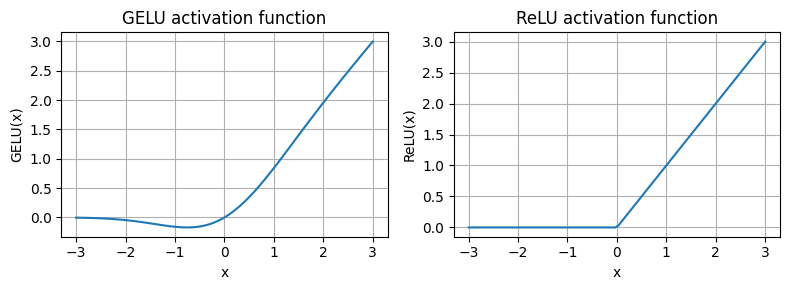

In [153]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [154]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [155]:
print(GPT_CONFIG_124M["emb_dim"])


768


In [156]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


### Shortcut Connections

In [157]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


In [158]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

In [159]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [160]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [161]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


### Transformer Block

In [162]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [163]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [164]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [165]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [166]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


### Entire GPT

In [167]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [168]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [169]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [170]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [171]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [172]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


### Generate Text By Random weights

In [173]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [174]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [175]:
model.eval() #A
#model = GPTModel(GPT_CONFIG_124M)
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [176]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


### Evaluate Generative Text Models

In [177]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [178]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [179]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"



token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [180]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [181]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [182]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [183]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


Cross-Entropy Loss

In [184]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0001,     0.0000])


In [185]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [186]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [187]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [188]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


Using Torch

In [189]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [190]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


Perplexity

In [191]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


### Calculate Train/Val Loss

In [192]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [193]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [194]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [195]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [196]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [197]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [198]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [199]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [200]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [201]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [202]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [203]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [204]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [205]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


### Training Loop for LLM

In [206]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [207]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [208]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [209]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

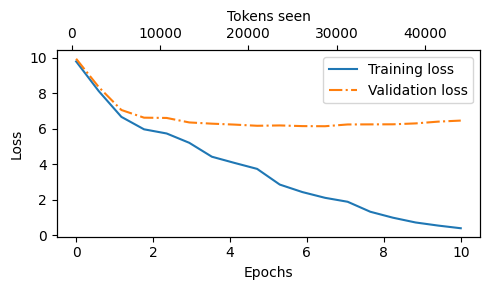

In [210]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Control Randomness

In [211]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [212]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


Temperature

In [213]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

In [214]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

next_token_logits2 = next_token_logits/0.1

next_token_logits3 = next_token_logits/5

In [215]:
probas = torch.softmax(next_token_logits2, dim=0)

print(probas)



tensor([    0.0000,     0.0000,     0.0000,     0.9910,     0.0000,     0.0000,
            0.0000,     0.0090,     0.0000])


In [216]:
probas = torch.softmax(next_token_logits3, dim=0)

print(probas)

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [217]:
probas = torch.softmax(next_token_logits, dim=0)

print(probas)

next_token_id = torch.argmax(probas).item()

print(next_token_id)

print(inverse_vocab[next_token_id])

tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])
3
forward


In [218]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [219]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [220]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

##Multinomial

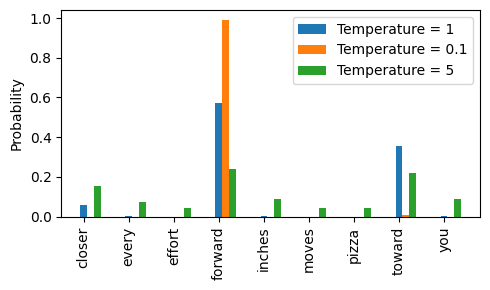

In [221]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

Top-k Sampling

In [222]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [223]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [224]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [225]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Top-k and Temperature

In [226]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [227]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


### Loading and Saving Model Weights

In [228]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

In [229]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [230]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [231]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

### OpenAI Pretrained Weights

In [232]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.20.0
tqdm version: 4.67.1


In [233]:
from gpt_download3 import download_and_load_gpt2

In [234]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [235]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [236]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [237]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [238]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [239]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [240]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [241]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [242]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on this side of the river?


# Fine-Tune for Classification

### Data Preprocessing

In [243]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [244]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [245]:
print(df["Label"].value_counts())


Label
ham     4825
spam     747
Name: count, dtype: int64


In [246]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [247]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [248]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder


In [249]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [250]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### Data Loader

In [251]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [252]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [253]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(test_dataset.max_length)

120


In [254]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [255]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [256]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


### Model Initialization

In [257]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [258]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

from gpt_download3 import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [259]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [260]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [261]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [262]:
for param in model.parameters():
    param.requires_grad = False

In [263]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [266]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [267]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [268]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [269]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


### Loss and Accuracy

In [275]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [276]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
print(probas)
label = torch.argmax(probas)
print("Class label:", label.item())

tensor([[    0.0005,     0.9995]])
Class label: 1


In [277]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [278]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [279]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"Running on {device} device.")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [280]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [281]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [282]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


### Fine_Tuning

In [283]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens 
            global_step += 1

            ## 130 batches: training, eval_Freq = 50 --> after 50 batches are processed in each epoch, we print train loss and val loss

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [284]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [285]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 8.17 mi

In [286]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

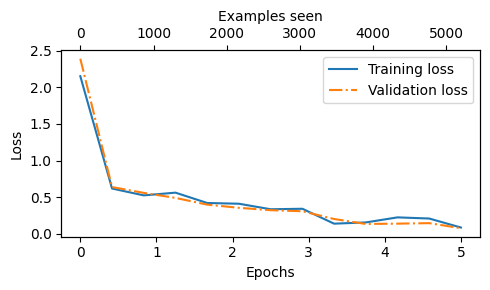

In [287]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

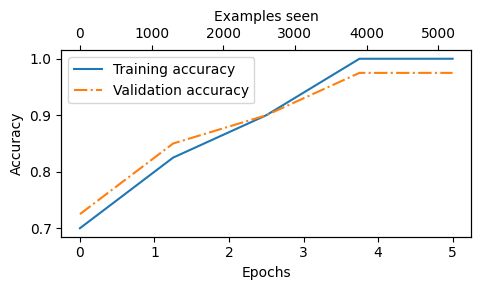

In [288]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [289]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


### Use LLM as Spam Classifier

In [290]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [291]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [292]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [293]:
torch.save(model.state_dict(), "review_classifier.pth")

In [294]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# Instruction Fine-Tuning

### Data Preparation

In [295]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


In [296]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [297]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [298]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [299]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [300]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [301]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [302]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### Training Batches

In [303]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [304]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [305]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [306]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [307]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [308]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [324]:
def customized_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [310]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [313]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [316]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [317]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)

targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


### DataLoader

In [337]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print("Device:", device)

Device: mps


In [338]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [339]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

### Load Pretrained LLM (Fundamental Model)

In [340]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/checkpoint


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/encoder.json


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/hparams.json


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.index


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.meta


/Users/mori/Personal/0.Code/2.GenAI/env_genAI/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [341]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [342]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [343]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


### Fine-Tuning

In [344]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [345]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 19.87874412536621
Validation loss: 19.92352752685547


In [346]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 19.995, Val loss 19.811
Ep 1 (Step 000005): Train loss 19.228, Val loss 19.256
Ep 1 (Step 000010): Train loss 18.891, Val loss 18.731
Ep 1 (Step 000015): Train loss 18.197, Val loss 18.227
Ep 1 (Step 000020): Train loss 17.731, Val loss 17.734
Ep 1 (Step 000025): Train loss 17.262, Val loss 17.257
Ep 1 (Step 000030): Train loss 16.598, Val loss 16.789
Ep 1 (Step 000035): Train loss 16.266, Val loss 16.352
Ep 1 (Step 000040): Train loss 15.851, Val loss 15.932
Ep 1 (Step 000045): Train loss 15.339, Val loss 15.503
Ep 1 (Step 000050): Train loss 15.015, Val loss 15.050


RuntimeError: MPS backend out of memory (MPS allocated: 12.83 GiB, other allocations: 5.12 GiB, max allowed: 18.13 GiB). Tried to allocate 196.32 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")